## Grid

Plot grid information

In [1]:
%pylab inline
from netCDF4 import Dataset # to work with NetCDF files
import numpy as np
import matplotlib.pyplot as plt # to generate plots
from mpl_toolkits.basemap import Basemap # plot on map projections
from glob import glob
import scipy as sp
import xarray as xr
from xarray.ufuncs import square, sqrt
import scipy.interpolate
import scipy.ndimage
from tqdm import tqdm_notebook

import sys, os
sys.path.append(os.path.join(os.getcwd(), '..'))  # so we can import ../exptdata
import exptdata
print('Available exptdata keys: ', [k for k in exptdata.exptdict.keys()])

Populating the interactive namespace from numpy and matplotlib


/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/distributed/config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)


Available exptdata keys:  ['1deg', '025deg', '01deg']


In [2]:
# add new ryf run
exptdata.exptdict['01deg_jra55v13_ryf9091'] = \
              {'model': 'access-om2-01',
               'expt': '01deg_jra55v13_ryf9091/',
               'desc': 'ACCESS-OM2-01 RYF 1990-91',
               'n_files': None,
#                'time_units': 'days since 0001-01-01',
               'time_units': 'days since 1988-01-01', # so .sel(time=slice(pd.datetime(1998,1,1),None)) removes first 10 years
               'offset': None,
               'exptdir': '/g/data3/hh5/tmp/cosima/access-om2-01/01deg_jra55v13_ryf9091/'}

In [3]:
figdir = ''
def savefigure(fname):
    plt.savefig(os.path.join(figdir, fname+'.png'),dpi=300, bbox_inches="tight")  # comment out to disable saving
    plt.savefig(os.path.join(figdir, fname+'.pdf'),dpi=300, bbox_inches="tight")  # comment out to disable saving
    return

In [4]:
def plotgrid(geolon_t,geolat_t,dxt,dyt,desc,model):
    plt.figure(figsize(9.5,12))
    clev = np.linspace(min(np.min(dxt), np.min(dyt)),max(np.max(dxt), np.max(dyt)),51)

    plt.subplot(1,2,1)
    map = Basemap(projection='cyl',llcrnrlat=-90,urcrnrlat=90,\
                llcrnrlon=-280,urcrnrlon=80,resolution='l')
    map.drawmapboundary(fill_color='gray') # background color - for non-ocean areas
    map.drawparallels(np.arange(-90.,91.,30.),labels=[True,False,False,False],linewidth=0.25)
    map.drawmeridians(np.arange(-270,81,45),labels=[False,False,False,True],linewidth=0.25)
    X, Y = map(geolon_t,geolat_t)
    # try to remove seams - BUG: doesn't work! Use cartopy instead?
#     X = exptdata.joinseams(X, tripole_flip=True, lon=True)
#     Y = exptdata.joinseams(Y, tripole_flip=True)
#     dxt = exptdata.joinseams(dxt)
#     dyt = exptdata.joinseams(dyt)

    p1=map.contourf(X,Y,dxt, cmap=plt.cm.viridis, levels=clev) #CMRmap_r, gist_stern_r
    plt.title('x-size of T cells in ' + desc)

    plt.subplot(1,2,2)
    map = Basemap(projection='cyl',llcrnrlat=-90,urcrnrlat=90,\
                llcrnrlon=-280,urcrnrlon=80,resolution='l')
    map.drawmapboundary(fill_color='gray') # background color - for non-ocean areas
    map.drawparallels(np.arange(-90.,91.,30.),labels=[True,False,False,False],linewidth=0.25)
    map.drawmeridians(np.arange(-270,81,45),labels=[False,False,False,True],linewidth=0.25)
#     X, Y = map(geolon_t,geolat_t) 
    p1=map.contourf(X,Y,dyt, cmap=plt.cm.viridis, levels=clev) #CMRmap_r, gist_stern_r
    plt.title('y-size of T cells in ' + desc)
    
    ax3 = plt.axes([0.92,0.43,0.02,0.14])

    cb = plt.colorbar(p1,cax=ax3,orientation='vertical')
    cb.ax.set_ylabel('dxt, dyt (km)')

    savefigure('grid_'+ekey)

In [5]:
# BUG: not plotting properly - switch to cartopy?
def plotgrid_tripole_closeup(geolon_t,geolat_t,dxt,dyt,desc,model):
    plt.figure(figsize(9.5,12))
    clmin = min(np.min(dxt), np.min(dyt))
    clev = np.linspace(clmin,2*clmin,51)


    plt.subplot(1,2,1)
    map = Basemap(projection='cyl',llcrnrlat=60,urcrnrlat=80,\
                llcrnrlon=-290,urcrnrlon=-270,resolution='l')
    map.drawmapboundary(fill_color='gray') # background color - for non-ocean areas
#     map.drawparallels(np.arange(-90.,91.,30.),labels=[True,False,False,False],linewidth=0.25)
#     map.drawmeridians(np.arange(-270,81,45),labels=[False,False,False,True],linewidth=0.25)
    X, Y = map(geolon_t,geolat_t)
    # try to remove seams - BUG: doesn't work! Use cartopy instead?
#     X = exptdata.joinseams(X, tripole_flip=True, lon=True)
#     Y = exptdata.joinseams(Y, tripole_flip=True)
#     dxt = exptdata.joinseams(dxt)
#     dyt = exptdata.joinseams(dyt)

    p1=map.contourf(X,Y,dyt, cmap=plt.cm.viridis, levels=clev) #CMRmap_r, gist_stern_r
    plt.title('y-size of T cells in ' + desc)

    plt.subplot(1,2,2)
    map = Basemap(projection='cyl',llcrnrlat=60,urcrnrlat=80,\
                llcrnrlon=-110,urcrnrlon=-90,resolution='l')
    map.drawmapboundary(fill_color='gray') # background color - for non-ocean areas
#     map.drawparallels(np.arange(-90.,91.,30.),labels=[True,False,False,False],linewidth=0.25)
#     map.drawmeridians(np.arange(-270,81,45),labels=[False,False,False,True],linewidth=0.25)
#     X, Y = map(geolon_t,geolat_t) 
    p1=map.contourf(X,Y,dyt, cmap=plt.cm.viridis, levels=clev) #CMRmap_r, gist_stern_r
    plt.title('y-size of T cells in ' + desc)
    
    ax3 = plt.axes([0.92,0.43,0.02,0.14])

    cb = plt.colorbar(p1,cax=ax3,orientation='vertical')
    cb.ax.set_ylabel('dxt, dyt (km)')

#     savefigure('grid_tripole_closeup'+ekey)

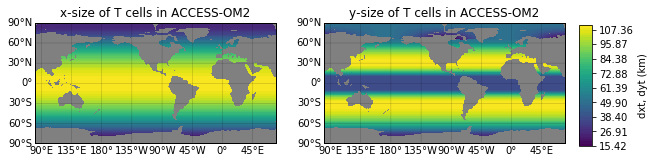

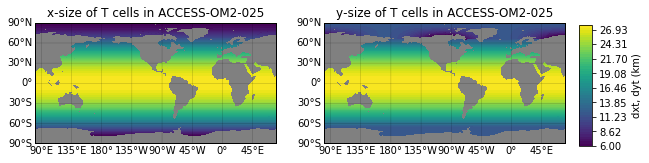

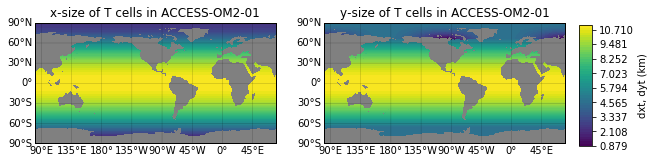

In [5]:
for ekey in exptdata.exptdict.keys():
    exptdir = exptdata.exptdict[ekey]['exptdir']
    desc = exptdata.exptdict[ekey]['desc']
    model = exptdata.exptdict[ekey]['model']
    gridFileList = glob(os.path.join(exptdir, 'output*/ocean/ocean_grid.nc'))
    gridFileList.sort()
    ncFile = Dataset(gridFileList[0],'r')
    dxt = ncFile.variables['dxt'][...]
    dyt = ncFile.variables['dyt'][...]
    geolon_t = ncFile.variables['geolon_t'][...]
    geolat_t = ncFile.variables['geolat_t'][...]
    ncFile.close()
    plotgrid(geolon_t,geolat_t,dxt/1000,dyt/1000,desc,model)

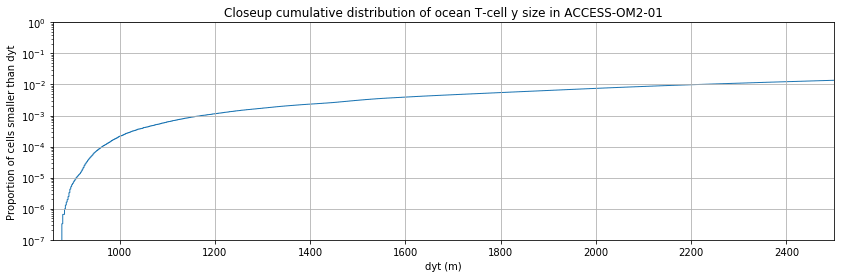

In [6]:
plt.figure(figsize=(14,4))
plt.hist(np.ma.ravel(dyt), bins=5500, log=True, density=True, histtype='step', cumulative=True);
# plt.hist(np.ma.ravel(dyt), bins=15000, log=True, density=True, histtype='step', cumulative=True);
# plt.hist(np.ma.ravel(dxt/1000), bins=1000, density=True, histtype='step',
#                            cumulative=True,label='x-size');
plt.xlim(860, 2500)
plt.ylim(1e-7,1)
plt.grid()
plt.xlabel('dyt (m)')
plt.ylabel('Proportion of cells smaller than dyt');
plt.title('Closeup cumulative distribution of ocean T-cell y size in '+desc);

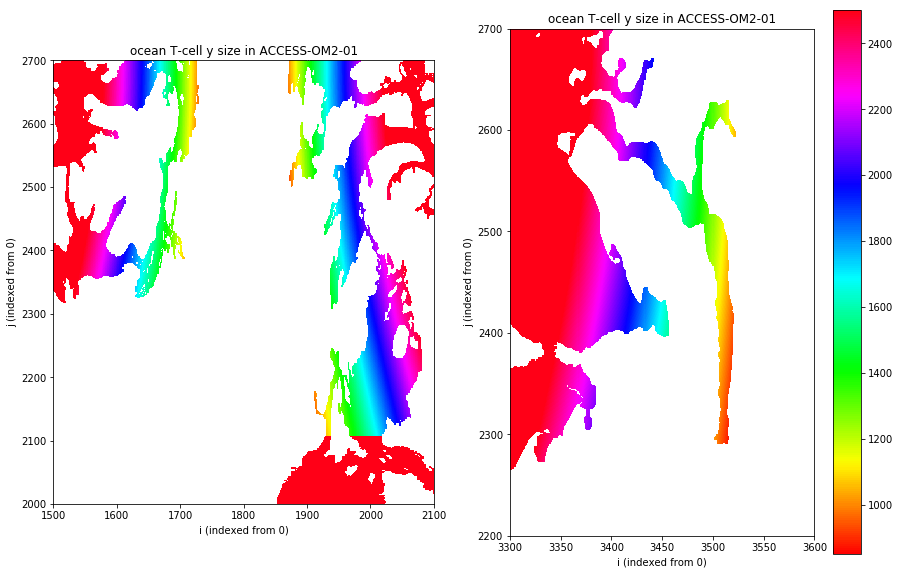

In [7]:
plt.figure(figsize=(15,10))

# plt.subplot(1,3,1)  # these are all >1000m
# plt.imshow(dyt, vmin=850, vmax=2000, origin='lower', cmap=plt.cm.hsv)
# # plt.colorbar()
# plt.xlim(0,500)
# plt.ylim(2700-500,2700)
# plt.title('ocean T-cell y size in '+desc)
# plt.xlabel('i (indexed from 0)')
# plt.ylabel('j (indexed from 0)');

plt.subplot(1,2,1)
plt.imshow(dyt, vmin=850, vmax=2500, origin='lower', cmap=plt.cm.hsv)
# plt.colorbar()
plt.xlim(1800-300,1800+300)
plt.ylim(2700-700,2700)
plt.title('ocean T-cell y size in '+desc)
plt.xlabel('i (indexed from 0)')
plt.ylabel('j (indexed from 0)');

plt.subplot(1,2,2)
plt.imshow(dyt, vmin=850, vmax=2500, origin='lower', cmap=plt.cm.hsv)
plt.colorbar()
plt.xlim(3600-300,3600)
plt.ylim(2700-500,2700)
plt.title('ocean T-cell y size in '+desc)
plt.xlabel('i (indexed from 0)')
plt.ylabel('j (indexed from 0)');
savefigure('grid_tripole_dyt'+ekey)

{0.0: ([<matplotlib.lines.Line2D at 0x7f4f2c57c7b8>],
  [Text(3421035.4162667366, -68284.14004524423, '0°')]),
 30.0: ([<matplotlib.lines.Line2D at 0x7f4f2c57cb38>],
  [Text(5387618.64956977, -68284.14004524423, '30°E')]),
 60.0: ([<matplotlib.lines.Line2D at 0x7f4f2c57ce48>], []),
 90.0: ([<matplotlib.lines.Line2D at 0x7f4f2d9c6198>], []),
 120.0: ([<matplotlib.lines.Line2D at 0x7f4f2d9c64a8>], []),
 150.0: ([<matplotlib.lines.Line2D at 0x7f4f2d9c67b8>], []),
 180.0: ([<matplotlib.lines.Line2D at 0x7f4f2d9c6ac8>], []),
 210.0: ([<matplotlib.lines.Line2D at 0x7f4f2d9c6dd8>], []),
 240.0: ([<matplotlib.lines.Line2D at 0x7f4f2d9d6128>],
  [Text(-68284.14004524423, 5387618.64956977, '120°W')]),
 270.0: ([<matplotlib.lines.Line2D at 0x7f4f2d9d6438>],
  [Text(-68284.14004524423, 3421035.4162667366, '90°W')]),
 300.0: ([<matplotlib.lines.Line2D at 0x7f4f2d9d6748>],
  [Text(-68284.14004524423, 1447623.768959178, '60°W')]),
 330.0: ([<matplotlib.lines.Line2D at 0x7f4f2d9d6a58>],
  [Text(144762

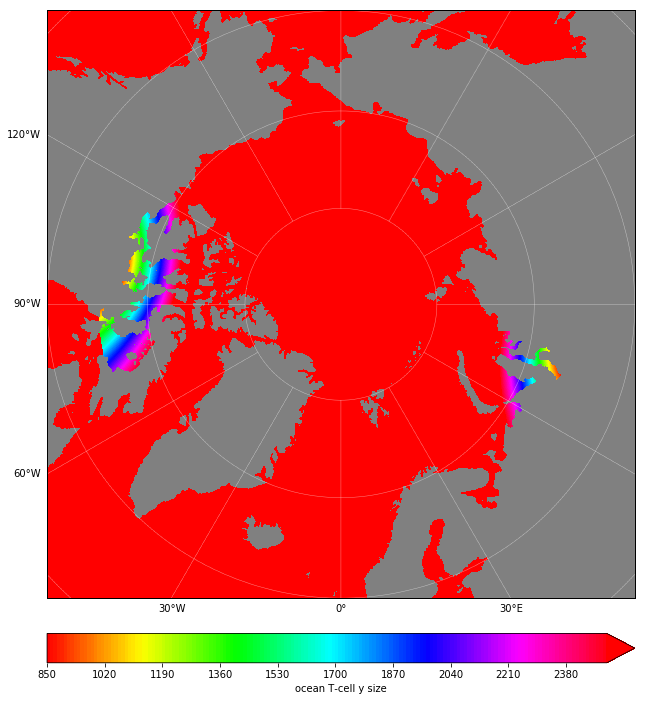

In [8]:
lon_t = exptdata.joinseams(geolon_t, tripole_flip=True, lon=True)
lat_t = exptdata.joinseams(geolat_t, tripole_flip=True)

levels = np.arange(850,2501,10)

m = Basemap(projection ='npstere',boundinglat=60,lon_0=0,resolution='l')
x,y = m(*(lon_t,lat_t))
plt.figure(figsize=(12,12))

model = exptdata.joinseams(dyt)
m = Basemap(projection ='npstere',boundinglat=60,lon_0=0,resolution='l')
m.drawmapboundary(fill_color='gray') # background color - for non-ocean areas
ctr = m.contourf(x,y,model,levels=levels,cmap=plt.cm.hsv, extend='max')
ctr.cmap.set_over(color='r', alpha=None)
cbar = m.colorbar(ctr, location = 'bottom', pad = "6%")
cbar.set_label('ocean T-cell y size')
parallels = np.arange(-80.,81,10.)
m.drawparallels(parallels,color='white',linewidth=0.5)
meridians = np.arange(0.,351.,30.)
m.drawmeridians(meridians,labels=[True,False,False,True],color='white',linewidth=0.5)

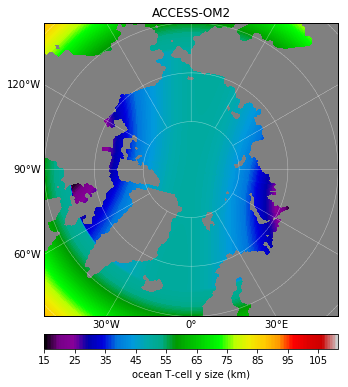

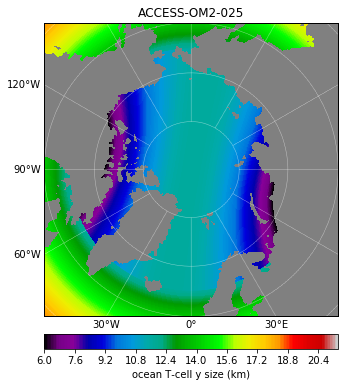

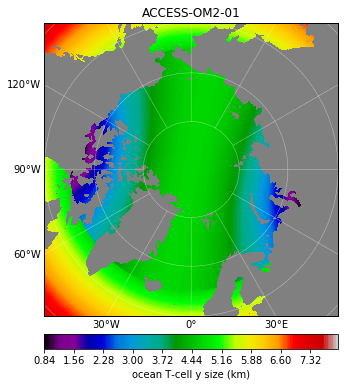

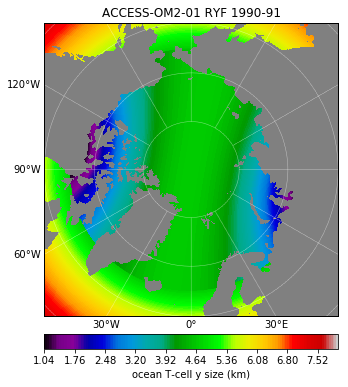

In [6]:
for ekey in exptdata.exptdict.keys():
    exptdir = exptdata.exptdict[ekey]['exptdir']
    desc = exptdata.exptdict[ekey]['desc']
    model = exptdata.exptdict[ekey]['model']
    gridFileList = glob(os.path.join(exptdir, 'output*/ocean/ocean_grid.nc'))
    gridFileList.sort()
    ncFile = Dataset(gridFileList[0],'r')
    dxt = ncFile.variables['dxt'][...]
    dyt = ncFile.variables['dyt'][...]
    geolon_t = ncFile.variables['geolon_t'][...]
    geolat_t = ncFile.variables['geolat_t'][...]
    ncFile.close()

    lon_t = exptdata.joinseams(geolon_t, tripole_flip=True, lon=True)
    lat_t = exptdata.joinseams(geolat_t, tripole_flip=True)

#     levels = np.arange(0,100000,1000)
    cmp = plt.get_cmap('nipy_spectral')

    m = Basemap(projection ='npstere',boundinglat=60,lon_0=0,resolution='l')
    x,y = m(*(lon_t,lat_t))
    plt.figure(figsize=(6,6))

    model = exptdata.joinseams(dyt)/1000
    m = Basemap(projection ='npstere',boundinglat=60,lon_0=0,resolution='l')
    m.drawmapboundary(fill_color='gray') # background color - for non-ocean areas
    ctr = m.contourf(x,y,model,levels=200,
                     #levels=levels,
                     cmap=cmp) #, extend='max')
#     ctr.cmap.set_over(color=cmp(255), alpha=None)
    cbar = m.colorbar(ctr, location = 'bottom', pad = "6%")
    cbar.set_label('ocean T-cell y size (km)')
    parallels = np.arange(-80.,81,10.)
    m.drawparallels(parallels,color='white',linewidth=0.5)
    meridians = np.arange(0.,351.,30.)
    m.drawmeridians(meridians,labels=[True,False,False,True],color='white',linewidth=0.5)
    plt.title(desc)
    
    savefigure('NH_grid_'+ekey)

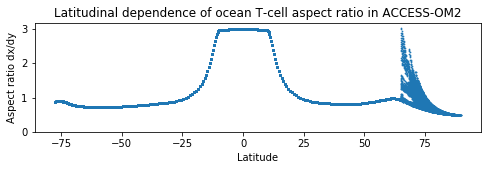

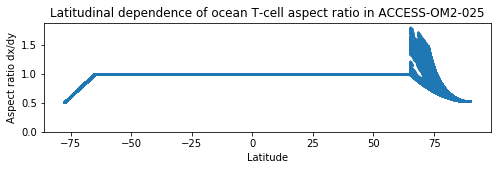

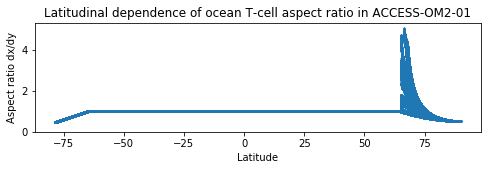

In [9]:
for ekey in exptdata.exptdict.keys():
    exptdir = exptdata.exptdict[ekey]['exptdir']
    desc = exptdata.exptdict[ekey]['desc']
    model = exptdata.exptdict[ekey]['model']
    gridFileList = glob(os.path.join(exptdir, 'output*/ocean/ocean_grid.nc'))
    gridFileList.sort()
    ncFile = Dataset(gridFileList[0],'r')
    dxt = ncFile.variables['dxt'][...]
    dyt = ncFile.variables['dyt'][...]
    geolon_t = ncFile.variables['geolon_t'][...]
    geolat_t = ncFile.variables['geolat_t'][...]
    ncFile.close()
    fig, ax = plt.subplots(figsize=(8, 2))
    plt.scatter(geolat_t,dxt/dyt,s=.5)
    plt.gca().set_ylim(bottom=0)
    plt.ylabel('Aspect ratio dx/dy')
    plt.xlabel('Latitude');
    plt.title('Latitudinal dependence of ocean T-cell aspect ratio in '+desc);
    plt.savefig('grid_aspect_'+ekey+'.png',dpi=300, bbox_inches="tight")

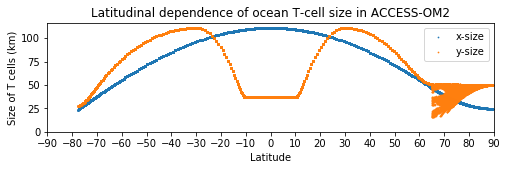

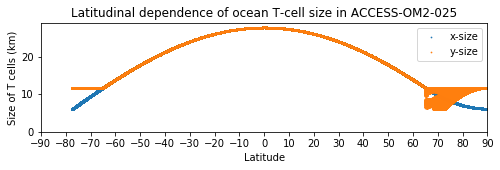

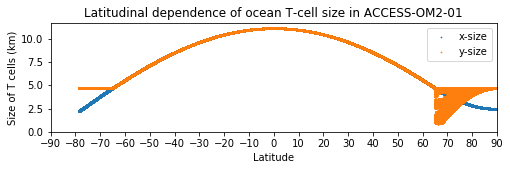

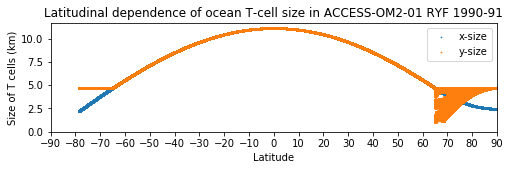

In [7]:
for ekey in exptdata.exptdict.keys():
    exptdir = exptdata.exptdict[ekey]['exptdir']
    desc = exptdata.exptdict[ekey]['desc']
    model = exptdata.exptdict[ekey]['model']
    gridFileList = glob(os.path.join(exptdir, 'output*/ocean/ocean_grid.nc'))
    gridFileList.sort()
    ncFile = Dataset(gridFileList[0],'r')
    dxt = ncFile.variables['dxt'][...]
    dyt = ncFile.variables['dyt'][...]
    geolon_t = ncFile.variables['geolon_t'][...]
    geolat_t = ncFile.variables['geolat_t'][...]
    ncFile.close()
    fig, ax = plt.subplots(figsize=(8, 2))
    plt.scatter(geolat_t,dxt/1000,s=.5, label='x-size')
    plt.scatter(geolat_t,dyt/1000,s=.5, label='y-size')
    plt.gca().set_ylim(bottom=0)
    plt.gca().set_xlim(-90,90)
    plt.xticks(range(-90,91,10))
    plt.ylabel('Size of T cells (km)')
    plt.xlabel('Latitude');
    plt.title('Latitudinal dependence of ocean T-cell size in '+desc);
    ax.legend(loc='upper right')
    plt.savefig('grid_scatter_'+ekey+'.png',dpi=300, bbox_inches="tight")
#     break

Global
1deg median: dxt=91.657074, dyt=51.36658 km
1deg min: dxt=23.821156, dyt=15.417367 km
1deg max: dxt=111.19446, dyt=111.18621 km
Arctic
1deg median: dxt=32.655483, dyt=47.436745 km
1deg min: dxt=24.653837, dyt=15.417367 km
1deg max: dxt=54.78055, dyt=56.60052 km
Antarctic
1deg median: dxt=43.048256, dyt=57.51775 km
1deg min: dxt=23.821156, dyt=27.516111 km
1deg max: dxt=54.556736, dyt=76.12059 km
Global
025deg median: dxt=18.055973052978516, dyt=18.055973052978516 km
025deg min: dxt=6.023071, dyt=6.0000024 km
025deg max: dxt=27.798666, dyt=27.798666 km
Arctic
025deg median: dxt=8.107551574707031, dyt=11.085968017578125 km
025deg min: dxt=6.169704, dyt=6.0000024 km
025deg max: dxt=13.863902, dyt=13.863902 km
Antarctic
025deg median: dxt=11.270404815673828, dyt=11.742027282714844 km
025deg min: dxt=6.023071, dyt=11.742027 km
025deg max: dxt=13.863902, dyt=13.863902 km
Global
01deg median: dxt=7.162562370300293, dyt=7.162562370300293 km
01deg min: dxt=2.1947086, dyt=0.87876093 km
01

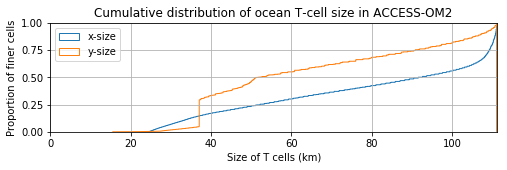

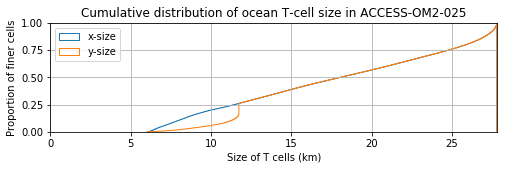

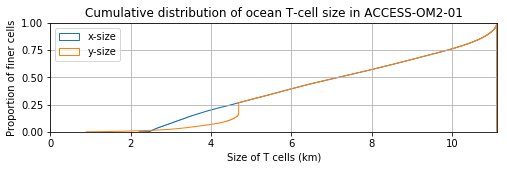

In [11]:
for ekey in exptdata.exptdict.keys():
    exptdir = exptdata.exptdict[ekey]['exptdir']
    desc = exptdata.exptdict[ekey]['desc']
    model = exptdata.exptdict[ekey]['model']
    gridFileList = glob(os.path.join(exptdir, 'output*/ocean/ocean_grid.nc'))
    gridFileList.sort()
    ncFile = Dataset(gridFileList[0],'r')
    dxt = ncFile.variables['dxt'][...]
    dyt = ncFile.variables['dyt'][...]
    geolat_t = ncFile.variables['geolat_t'][...]
    ncFile.close()
    fig, ax = plt.subplots(figsize=(8, 2))
    ax.hist(np.ma.ravel(dxt/1000), bins=1000, density=True, histtype='step',
                           cumulative=True,label='x-size');
    ax.hist(np.ma.ravel(dyt/1000), bins=1000, density=True, histtype='step',
                           cumulative=True,label='y-size');
    ax.autoscale(enable=True, axis='x', tight=True)
    ax.autoscale(enable=True, axis='y', tight=True)
    plt.gca().set_xlim(left=0)
    plt.yticks([0, .25, .5, .75, 1])
    plt.grid()
    plt.xlabel('Size of T cells (km)')
    plt.ylabel('Proportion of finer cells');
    plt.title('Cumulative distribution of ocean T-cell size in '+desc);
    ax.legend(loc='upper left')
    savefigure('grid_hist_'+ekey)
    dxtNkm = dxt[geolat_t>=60]/1000
    dytNkm = dyt[geolat_t>=60]/1000
    dxtSkm = dxt[geolat_t<=-60]/1000
    dytSkm = dyt[geolat_t<=-60]/1000
    print('Global')
    print(ekey+' median: dxt='+str(np.ma.median(dxt/1000))+', dyt='+str(np.ma.median(dyt/1000))+' km')
    print(ekey+' min: dxt='+str(np.ma.min(dxt/1000))+', dyt='+str(np.ma.min(dyt/1000))+' km')
    print(ekey+' max: dxt='+str(np.ma.max(dxt/1000))+', dyt='+str(np.ma.max(dyt/1000))+' km')
    print('Arctic')
    print(ekey+' median: dxt='+str(np.ma.median(dxtNkm))+', dyt='+str(np.ma.median(dytNkm))+' km')
    print(ekey+' min: dxt='+str(np.ma.min(dxtNkm))+', dyt='+str(np.ma.min(dytNkm))+' km')
    print(ekey+' max: dxt='+str(np.ma.max(dxtNkm))+', dyt='+str(np.ma.max(dytNkm))+' km')
    print('Antarctic')
    print(ekey+' median: dxt='+str(np.ma.median(dxtSkm))+', dyt='+str(np.ma.median(dytSkm))+' km')
    print(ekey+' min: dxt='+str(np.ma.min(dxtSkm))+', dyt='+str(np.ma.min(dytSkm))+' km')
    print(ekey+' max: dxt='+str(np.ma.max(dxtSkm))+', dyt='+str(np.ma.max(dytSkm))+' km')


In [17]:
# generate latex table of min, median and max, 
# and also min, median, max in N and S polar regions to which ice is mostly confined (from 60 to the pole)
for ekey in exptdata.exptdict.keys():
    exptdir = exptdata.exptdict[ekey]['exptdir']
    desc = exptdata.exptdict[ekey]['desc']
    model = exptdata.exptdict[ekey]['model']
    gridFileList = glob(os.path.join(exptdir, 'output*/ocean/ocean_grid.nc'))
    gridFileList.sort()
    ncFile = Dataset(gridFileList[0],'r')
    dxtkm = ncFile.variables['dxt'][...]/1000
    dytkm = ncFile.variables['dyt'][...]/1000
    geolat_t = ncFile.variables['geolat_t'][...]
    ncFile.close()
    dxtNkm = dxtkm[geolat_t>=60]
    dytNkm = dytkm[geolat_t>=60]
    dxtSkm = dxtkm[geolat_t<=-60]
    dytSkm = dytkm[geolat_t<=-60]
    if ekey == '01deg':
        dp = 2
    else:
        dp = 1
    print (r'{\small '+model.upper()+' dx} & ',
           ' & '.join([str(round(n,dp)) for n in [np.ma.min(dxtkm), np.ma.median(dxtkm), np.ma.max(dxtkm), ]]),' & ',
           ' & '.join([str(round(n,dp)) for n in [np.ma.min(dxtNkm), np.ma.median(dxtNkm), np.ma.max(dxtNkm), ]]),' & ',
           ' & '.join([str(round(n,dp)) for n in [np.ma.min(dxtSkm), np.ma.median(dxtSkm), np.ma.max(dxtSkm), ]]),
           r'\\'
          )
    print (r'{\small '+model.upper()+' dy} & ',
           ' & '.join([str(round(n,dp)) for n in [np.ma.min(dytkm), np.ma.median(dytkm), np.ma.max(dytkm), ]]),' & ',
           ' & '.join([str(round(n,dp)) for n in [np.ma.min(dytNkm), np.ma.median(dytNkm), np.ma.max(dytNkm), ]]),' & ',
           ' & '.join([str(round(n,dp)) for n in [np.ma.min(dytSkm), np.ma.median(dytSkm), np.ma.max(dytSkm), ]]),
           r'\\'
          )
    print (r'{\small '+model.upper()+' dx/dy} & ',
           ' & '.join([str(round(n,2)) for n in [np.ma.min(dxtkm/dytkm), np.ma.median(dxtkm/dytkm), np.ma.max(dxtkm/dytkm), ]]),' & ',
           ' & '.join([str(round(n,2)) for n in [np.ma.min(dxtNkm/dytNkm), np.ma.median(dxtNkm/dytNkm), np.ma.max(dxtNkm/dytNkm), ]]),' & ',
           ' & '.join([str(round(n,2)) for n in [np.ma.min(dxtSkm/dytSkm), np.ma.median(dxtSkm/dytSkm), np.ma.max(dxtSkm/dytSkm), ]]),
           r'\\'
          )
    print(r'\hline')

{\small ACCESS-OM2 dx} &  23.8 & 91.7 & 111.2  &  24.7 & 32.7 & 54.8  &  23.8 & 43.0 & 54.6 \\
{\small ACCESS-OM2 dy} &  15.4 & 51.4 & 111.2  &  15.4 & 47.4 & 56.6  &  27.5 & 57.5 & 76.1 \\
{\small ACCESS-OM2 dx/dy} &  0.49 & 0.92 & 3.04  &  0.49 & 0.74 & 3.04  &  0.72 & 0.75 & 0.91 \\
\hline
{\small ACCESS-OM2-025 dx} &  6.0 & 18.1 & 27.8  &  6.2 & 8.1 & 13.9  &  6.0 & 11.3 & 13.9 \\
{\small ACCESS-OM2-025 dy} &  6.0 & 18.1 & 27.8  &  6.0 & 11.1 & 13.9  &  11.7 & 11.7 & 13.9 \\
{\small ACCESS-OM2-025 dx/dy} &  0.51 & 1.0 & 1.82  &  0.53 & 0.8 & 1.82  &  0.51 & 0.96 & 1.0 \\
\hline
{\small ACCESS-OM2-01 dx} &  2.19 & 7.16 & 11.12  &  2.47 & 3.29 & 5.55  &  2.19 & 4.52 & 5.55 \\
{\small ACCESS-OM2-01 dy} &  0.88 & 7.16 & 11.12  &  0.88 & 4.39 & 5.55  &  4.7 & 4.7 & 5.55 \\
{\small ACCESS-OM2-01 dx/dy} &  0.47 & 1.0 & 5.1  &  0.52 & 0.81 & 5.1  &  0.47 & 0.96 & 1.0 \\
\hline


In [13]:
# copied from windrotation.ipynb
for ekey in exptdata.exptdict.keys():
    exptdir = exptdata.exptdict[ekey]['exptdir']
    desc = exptdata.exptdict[ekey]['desc']
    model = exptdata.exptdict[ekey]['model']
    gridFileList = glob(os.path.join(exptdir, 'output*/ocean/ocean_grid.nc'))
    gridFileList.sort()
    ncFile = Dataset(gridFileList[0],'r')
    geolon_c = ncFile.variables['geolon_c'][...]
    geolat_c = ncFile.variables['geolat_c'][...]
    geolat_t = ncFile.variables['geolat_t'][...]
    ncFile.close()
#     np.set_printoptions(threshold=100000)
    print(model)
    print('longitude of tripoles')
    print(np.unique(geolon_c[-1,:]))
    print('latitude of tripoles is between')
    # for j in range(momgrid_ulat.shape[-1]):
    for j,row in enumerate(geolat_c):
        if np.size(np.unique(row))>2:
            break
    maxnontripolej=j-1
    print(np.ma.mean(geolat_c[j-1,:]))
    print(np.ma.mean(geolat_c[j,:]))
    print('min latitude of ocean cells (not grid!)')
    print(np.ma.min(geolat_c))
    print(np.ma.min(geolat_t))






access-om2
longitude of tripoles
[-280.0 -100.0 80.0]
latitude of tripoles is between
65.0
65.342574949187
min latitude of ocean cells (not grid!)
-77.75317
-77.876625
access-om2-025
longitude of tripoles
[-280.0 -100.0 80.0 --]
latitude of tripoles is between
64.97313745471014
65.0559273097826
min latitude of ocean cells (not grid!)
-78.17304
-78.22584
access-om2-01
longitude of tripoles
[-280.0 -100.0 80.0 --]
latitude of tripoles is between
64.99430443548387
65.02802419354839
min latitude of ocean cells (not grid!)
-79.566895
-79.58801


ACCESS-OM2 	&	 50 	&	 2.3	&	93.0	&	219.6	&	5363.5 \\
ACCESS-OM2-025 	&	 50 	&	 2.3	&	93.0	&	219.6	&	5363.5 \\
ACCESS-OM2-01 	&	 75 	&	 1.1	&	42.6	&	198.4	&	5808.7 \\


/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


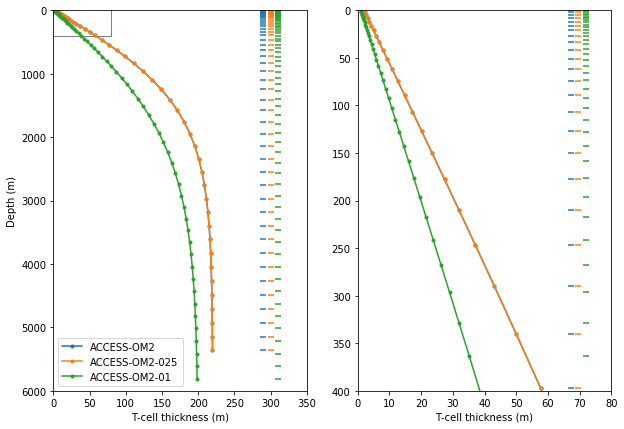

In [14]:
# vertical grid
plt.figure(figsize=(10,7))
for i, ekey in enumerate(exptdata.exptdict.keys()):
    exptdir = exptdata.exptdict[ekey]['exptdir']
    desc = exptdata.exptdict[ekey]['desc']
    model = exptdata.exptdict[ekey]['model']
    gridFileList = glob(os.path.join(exptdir, 'output*/ocean/ocean.nc'))
    gridFileList.sort()
    ncFile = Dataset(gridFileList[0],'r')
    st_edges_ocean = ncFile.variables['st_edges_ocean'][...]
    ncFile.close()
    dz = st_edges_ocean[1:] - st_edges_ocean[0:-1]
    print (model.upper(), '\t&\t', len(dz), '\t&\t',
       '\t&\t'.join([str(round(n,1)) for n in [np.ma.min(dz), np.ma.median(dz), np.ma.max(dz), np.ma.max(st_edges_ocean)]]),
       r'\\')

#     coords for zoom
    subx = [0, 80]
    suby = [0, 400]

    plt.subplot(1,2,1)
    if i==0:
        plt.plot(subx+[subx[1]],[suby[1], suby[1], suby[0]],'k',linewidth=0.5)
    plt.plot(dz, st_edges_ocean[1:], marker='o', markersize=3, label=model.upper())
    plt.scatter(np.full(len(st_edges_ocean),280+10*(i+1)), st_edges_ocean, marker='_')
    plt.xlabel('T-cell thickness (m)')
    plt.ylabel('Depth (m)')
    plt.xlim([0, 350])
    plt.ylim([0, 6000])
    plt.gca().invert_yaxis()
    plt.legend(loc='lower left')

    plt.subplot(1,2,2)
    plt.plot(dz, st_edges_ocean[1:], marker='o', markersize=3, label=model.upper())
    plt.scatter(np.full(len(st_edges_ocean), 65+2.3*(i+1)), st_edges_ocean, marker='_')
    plt.xlabel('T-cell thickness (m)')
#     plt.ylabel('Depth (m)')
    plt.xlim(subx)
    plt.ylim(suby)
    plt.gca().invert_yaxis()
#     plt.legend(loc='lower left')

savefigure('vgrid')
